In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import IPython
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from scipy import signal
import itertools

# Cutomozied library that includes functions defined in this task
from library_util import square, cubic, sqrt, log, time_delay_embedding


### Pre-process Data

In [2]:
# Process the Excel file
file=pd.ExcelFile('data/Wind_data.xlsx')
df_train_raw=pd.read_excel(file,'Train')
df_pred_raw=pd.read_excel(file,'Predict')
df_train_raw["DATETIME"]=pd.to_datetime(df_train_raw["DATETIME"])
df_pred_raw["DATETIME"]=pd.to_datetime(df_pred_raw["DATETIME"])
# Setting DT as index
df_train_raw.set_index('DATETIME', inplace=True)
df_pred_raw.set_index('DATETIME', inplace=True)
df_train=df_train_raw.copy()
# Check the range of datetime in train and pred
print(list(df_train_raw.index)[::len(df_train_raw)-1])
print(list(df_pred_raw.index)[::len(df_pred_raw)-1])

[Timestamp('2019-08-07 00:00:00'), Timestamp('2020-01-07 23:00:00')]
[Timestamp('2020-01-09 00:00:00'), Timestamp('2020-01-12 20:00:00')]


##### From the start and end datetime of the training and test sets, we see a gap of 1 day data (i.e., 2020-01-08). Highly likely, the prediction on CF will be more dependant on the features from WS at the same timestamp, rather than the seasonal pattern identified from the data based on the time lag information.
##### In the next step, we'll check how many datetime rows are missing in the training data and augment these values with interpolation method.

In [3]:
# # Make sure the data has clear frequency of 1 hour.
df_train=df_train.resample('1H').mean()

# Check if anydata is missing. 
value = df_train.isnull().values.any()
print(value)
# Compare the length of df_train_raw and df_train to get the number of missing values
print(len(df_train)-len(df_train_raw))

# 61 Missing value detected, use 'interpolate' method in pandas to replace missing values with the interpolation of two adjacent points.
df_train=df_train.interpolate()

# Check if anydata is still missing.
value = df_train.isnull().values.any()
print(value)
# No NAN is detected this time.

# Check whether any value is 0 to avoid -inf after log transformation.
print(df_train.eq(0).any().any())
# No zero is detected.

True
61
False
False


### Feature Selection

##### Note: Intuitively, wind power (WS) is highly correlated with the electricity output (CF) if the geographical location is close enough to the power plant. However, the original dataset includes WS data at more than 112 locations. WS data that come from adjacent geographhical locations may carry redundant information, which may result in 'overfitting' in the following model fitting. Thus, the goal in this step is to 

  - Select features (WS) that are highly correlated with CF
  - Remove redundant features (WS) to avoid overfitting

##### The important features can be identified either through Pearson's correlation coefficient by setting proper threshold, or use different wrapper methods such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE. In this task, I used Pearson's correlation due to its simplicity and computational efficiency compared with wrapper methods.


In [4]:
## In the first step, identify features that are correlated with outputs. 
#  I tested different thresholds of 0.5, 0.6, 0.7, 0.8, 0.9. 
#  Here, we set a lower threshold (i.e., 0.5) to avoid losing useful features. 
#  Also, there will be another round of dimension reduction using the wrapper methods within the ML model. 
#  So here, it's OK to be conservative to select more features.
cor = df_train.corr()
#Correlation with output variable
cor_target = abs(cor["CF"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
df_selected=df_train[relevant_features.index]
df_selected=df_selected.drop('CF',axis=1)
df_selected

# After the first step, 87 feature remains.

,WS_1133733,WS_1156770,WS_1193865,WS_1366338,WS_1366351,WS_1369320,WS_1461024,WS_1481513,WS_1504146,WS_1513782,...,WS_78207,WS_78208,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
DATETIME,,,,,,,,,,,,,,,,,,,,,
2019-08-07 00:00:00,10.35,8.99,8.90,8.81,8.74,11.14,6.13,15.46,10.70,9.66,...,9.82,11.12,9.31,11.63,10.72,10.55,11.41,10.77,10.17,9.24
2019-08-07 01:00:00,9.70,8.28,7.98,7.75,7.88,10.49,5.84,14.90,10.33,9.59,...,9.21,10.47,9.50,11.10,11.02,9.91,11.16,10.98,10.16,9.09
2019-08-07 02:00:00,9.04,7.39,7.78,7.55,7.70,10.12,5.81,14.22,10.01,9.59,...,8.40,10.10,9.46,10.74,11.19,9.52,11.00,11.10,10.04,9.04
2019-08-07 03:00:00,8.78,7.49,7.82,7.53,7.77,9.65,5.32,13.53,9.99,9.44,...,8.24,9.67,9.45,10.65,11.27,9.11,10.93,11.18,10.20,8.89
2019-08-07 04:00:00,8.23,6.88,6.65,6.40,6.60,9.21,5.25,12.84,9.31,9.20,...,7.61,9.24,9.30,9.78,10.85,8.64,10.69,10.83,9.88,8.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 19:00:00,1.56,1.62,2.23,1.77,2.42,1.42,1.28,0.86,1.75,1.54,...,1.41,1.41,1.04,1.48,1.55,1.94,1.72,1.30,1.22,1.60
2020-01-07 20:00:00,1.51,1.55,2.36,2.06,2.45,1.30,1.32,0.79,1.33,1.84,...,1.72,1.32,0.88,1.12,1.32,1.87,1.81,1.42,1.05,1.87
2020-01-07 21:00:00,1.51,1.62,2.47,2.48,2.47,1.41,1.51,0.64,1.21,1.99,...,1.76,1.26,1.28,0.87,1.37,1.83,2.08,1.44,1.32,2.05


Index(['WS_1133733', 'WS_1193865', 'WS_1461024', 'WS_1481513', 'WS_1513782',
       'WS_1571308', 'WS_1820276', 'WS_2455069', 'WS_594133', 'WS_914573'],
      dtype='object')


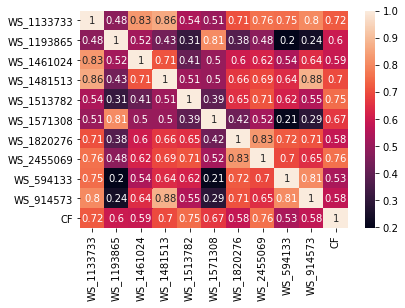

In [5]:
## In the second step, the selected features that are highly correlationed (i.e., cor>0.95 in this study) with each other will be removed, 
## only one feature from each highly correlated pair will be kept to avoid overfitting. 
corr = df_selected.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = df_selected.columns[columns]
print(selected_columns)
df_train_selected=df_selected[selected_columns]
Y0=df_train.loc[:, 'CF']
X0=df_train_selected.copy()
df_train_selected=df_train_selected.assign(CF = Y0.tolist())
sns.heatmap(df_train_selected.corr(),annot=True)
# After the feature selection, 10 locations were selected as the canidate variables to be used in the model fitting.


### Data Visualizatin with Different Frequencies (H, day, week)

##### Monthly review is not meaningful since less than 6 month data are known.

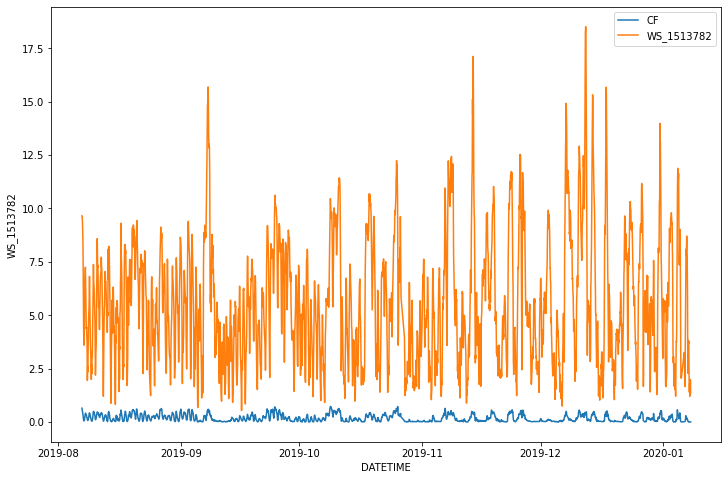

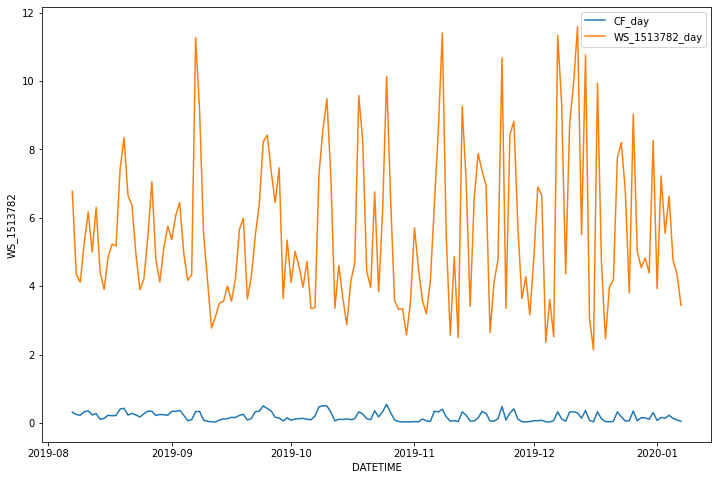

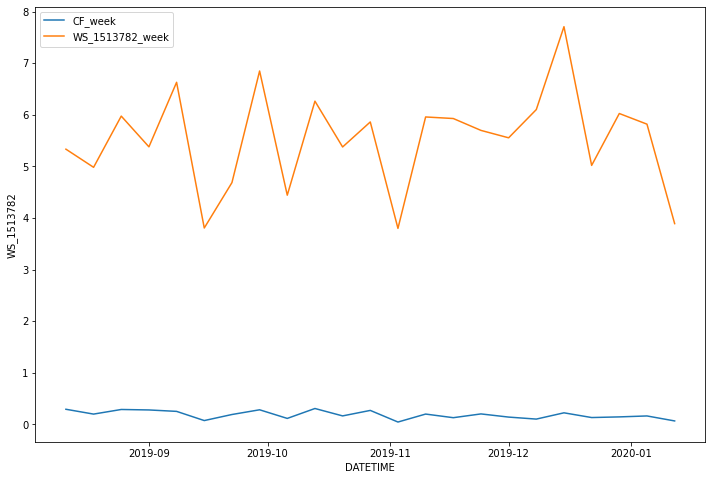

In [6]:
# Resample the df with different frequencies
df_train_day=df_train.resample('D').mean()
df_train_week=df_train.resample('W').mean()
# Visualize Hourly Trends of electricity output (CF) and most correlated WS
plt.figure(figsize=(12,8))
sns.lineplot(x=df_train.index, y=df_train['CF'])
sns.lineplot(x=df_train.index, y=df_train['WS_1513782'])
plt.legend(['CF', 'WS_1513782'])

# Visualize Daily Trends of electricity output (CF) and most correlated WS
plt.figure(figsize=(12,8))
sns.lineplot(x=df_train_day.index, y=df_train_day['CF'])
sns.lineplot(x=df_train_day.index, y=df_train_day['WS_1513782'])
plt.legend(['CF_day', 'WS_1513782_day'])

# Visualize Weekly Trends of electricity output (CF) and most correlated WS
plt.figure(figsize=(12,8))
sns.lineplot(x=df_train_week.index, y=df_train_week['CF'])
sns.lineplot(x=df_train_week.index, y=df_train_week['WS_1513782'])
plt.legend(['CF_week', 'WS_1513782_week'])

# No clear seasonal pattern is observed.

### Initial thoughts before determining the method to solve this task

##### The methods for time-series forecasting can be generally classified into two categories:

  - Statistical Methods: ARIMA (univariate), SARIMA (univariate), SARIMAX (multivariate), TBATS (univariate), Prophet (both), ...
  - Machine Learning Methods: Support Vector Machine, Random Forest, XGBoost, Neural Network, Gaussian Process

##### Among these two methods, the statistical methods mainly rely on the seasonal pattern, autoregression with the histotical data. While ML methods mainly rely on the correlation between input and output variables. In this task, strong correlation between the WS and CF is expected and identified. Besides, the data only included half year data, where no obvious seasonal pattern is identified. Last but not least, there is a gap of 24 hours between training and test (Predition tab), the WS data are unknown. 

##### Thus, I expect a ML model that can identify the pattern between WS and CF will shown better performance than a statistical model in this task. I'll start by comparing two ML models, random forest and XGBoost.

In [8]:
# Train test split
# I'll start with a test size of 0.2. However, other test sizes (0.1, 0.3) are also used to make sure evalation results are consistent.

df_train_selected=df_selected[selected_columns]

# Prepare input/ouput for model training with selected WS data
Y0=df_train.loc[:, 'CF']
X0=df_train_selected.copy()
X_tr0, X_ts0, Y_tr0, Y_ts0 = train_test_split(X0, Y0, test_size=0.2, shuffle=False)

In [9]:
# Start by building a baseline model to compare the performance of 
# RF and XGBoost model with the original feature without parameter tuning

import time

start_time1 = time.time()

# fitting a RF model with selected features
model_RF0 = RandomForestRegressor(random_state=1)
model_RF0.fit(X_tr0, Y_tr0)
# getting forecasts for the test set
pred_RF0 = model_RF0.predict(X_ts0)


# computing MAE error
print(f"MAE of RF with selected features is {mae(Y_ts0, pred_RF0)}")

print("RF model fitting takes %s seconds" % (time.time() - start_time1))

start_time2 = time.time()

# fitting a XGB model with selected features
model_xgb0 = xgboost.XGBRegressor()
model_xgb0.fit(X_tr0, Y_tr0)
pred_XGB0 = model_xgb0.predict(X_ts0)

# computing MAE error
print(f"MAE of XGBoost with selected features is {mae(Y_ts0, pred_XGB0)}")

print("XGB model fitting takes %s seconds" % (time.time() - start_time2))

# From the result (fixed the random_state to address the uncertainty during RF model fitting), 
# RF achieved better performance than XGBoost. 
# However, the RF model fitting takes more computational time (1.2s vs 0.2s). 

MAE of RF with selected features is 0.04723595766537493
RF model fitting takes 1.388535976409912 seconds
MAE of XGBoost with selected features is 0.050184173463418594
XGB model fitting takes 0.20979976654052734 seconds


Text(2019-12-10 06:00:00, 0.38187666217445115, 'mae_rf_selected=0.0472\n mae_xgb_selected=0.0502')

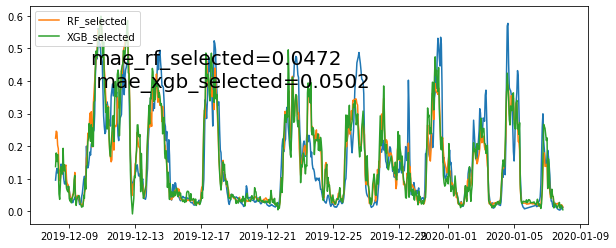

In [10]:
# Visualize the prediction results
plt.figure(figsize=(10,4))
# plt.plot(Y_tr.index,Y_tr.values)
plt.plot(Y_ts0.index,Y_ts0.values)
plt.plot(Y_ts0.index,pred_RF0,label='RF_selected')
plt.plot(Y_ts0.index,pred_XGB0,label='XGB_selected')
t='mae_rf_selected='+str(round(mae(Y_ts0, pred_RF0),4))+'\n mae_xgb_selected='+str(round(mae(Y_ts0, pred_XGB0),4))
plt.legend(loc='upper left')
plt.text(Y_ts0.index[50], Y_ts0.iloc[50]+0.2, t, fontsize=20)

# From the results, both predictions capture the overall trend (Peaks and valleys) of the CF in the test set.
# Accuracy of RF is slightly higher than that of XGB, however, the model fitting in XGB is faster in terms of computatinal time.

### Feature Augmentation

##### In this section, I'll investigate whether adding more features genereated using the existing columns will improve the prediction accuracy. The existing features may miss some key informations, such as higher orders, interactions between different variables. We can capture this information by feature transformation.
##### On the other hand, in time series analysis, the historical data of WS with certain time lag (e.g., (t-1), (t-12)...) can also be important in predicting the current CF. However, in this task, this is not applicable since there is one-day data missing before the test set in the Predictino tab (i.e., no short term historical WS data avaiable for the first few rows of the test data).

In [11]:
# Univariate feature transformation with higher order polynomials up to the 3rd order.
# It should be mentioned that I used the original 112 WS data as the base for generating the higher order polynomials
# This is because the previous Pearson's coefficient only accounts for linear (1st order) dependancy, 
# it might be possible that the correlation becomes higher after the feature transformation.

X_raw=df_train.drop('CF',axis=1)
colnames=X_raw.columns.tolist()

# Check whether any value is 0 to avoid -inf after log transformation.
print(X_raw.eq(0).any().any())

Univariate_Transformation = {
    'squre': square,
    'cubic': cubic,
    'sqrt': sqrt,
    'log': log,
}

univariate_features = {}
# for each column in the data
for col in colnames:
    # get lags for that column
    X_col = X_raw.iloc[:, X_raw.columns.str.startswith(col)]
    # for each summary stat
    for feat, func in Univariate_Transformation.items():
        # compute that stat along the rows
        univariate_features[f'{col}_{feat}'] = X_col.apply(func, axis=1)
# concatenate features into a pd.DF
univariate_features_df = pd.concat(univariate_features, axis=1)
univariate_features_df.columns = univariate_features_df.columns.droplevel(1)
univariate_features_df

# After this step, 448 features are added.

False


,WS_1133733_squre,WS_1133733_cubic,WS_1133733_sqrt,WS_1133733_log,WS_1156770_squre,WS_1156770_cubic,WS_1156770_sqrt,WS_1156770_log,WS_1156968_squre,WS_1156968_cubic,...,WS_918665_sqrt,WS_918665_log,WS_920775_squre,WS_920775_cubic,WS_920775_sqrt,WS_920775_log,WS_921049_squre,WS_921049_cubic,WS_921049_sqrt,WS_921049_log
DATETIME,,,,,,,,,,,,,,,,,,,,,
2019-08-07 00:00:00,107.1225,1108.717875,3.217142,2.336987,80.8201,726.572699,2.998333,2.196113,20.8849,95.443993,...,3.281768,2.376764,103.4289,1051.871913,3.189044,2.319442,85.3776,788.889024,3.039737,2.223542
2019-08-07 01:00:00,94.0900,912.673000,3.114482,2.272126,68.5584,567.663552,2.877499,2.113843,33.4084,193.100552,...,3.313608,2.396075,103.2256,1048.772096,3.187475,2.318458,82.6281,751.089429,3.014963,2.207175
2019-08-07 02:00:00,81.7216,738.763264,3.006659,2.201659,54.6121,403.583419,2.718455,2.000128,38.5641,239.483061,...,3.331666,2.406945,100.8016,1012.048064,3.168596,2.306577,81.7216,738.763264,3.006659,2.201659
2019-08-07 03:00:00,77.0884,676.836152,2.963106,2.172476,56.1001,420.189749,2.736786,2.013569,41.3449,265.847707,...,3.343651,2.414126,104.0400,1061.208000,3.193744,2.322388,79.0321,702.595369,2.981610,2.184927
2019-08-07 04:00:00,67.7329,557.441767,2.868798,2.107786,47.3344,325.660672,2.622975,1.928619,46.3761,315.821241,...,3.290897,2.382320,97.6144,964.430272,3.143247,2.290513,75.1689,651.714363,2.944486,2.159869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 19:00:00,2.4336,3.796416,1.249000,0.444686,2.6244,4.251528,1.272792,0.482426,5.9536,14.526784,...,1.140175,0.262364,1.4884,1.815848,1.104536,0.198851,2.5600,4.096000,1.264911,0.470004
2020-01-07 20:00:00,2.2801,3.442951,1.228821,0.412110,2.4025,3.723875,1.244990,0.438255,4.5369,9.663597,...,1.191638,0.350657,1.1025,1.157625,1.024695,0.048790,3.4969,6.539203,1.367479,0.625938
2020-01-07 21:00:00,2.2801,3.442951,1.228821,0.412110,2.6244,4.251528,1.272792,0.482426,5.8564,14.172488,...,1.200000,0.364643,1.7424,2.299968,1.148913,0.277632,4.2025,8.615125,1.431782,0.717840


In [12]:

# # # Extract bivariate feature

# # # In the initial version, I included more features (such as rolling mean, covariance, co_integration...) 
# # # since the WS data with different time lag were also used as input features.
# # # However, I then realized that the 2020-01-08 WS data are missing from the test data. Those time lag data and the statistics related to the 
# # # time lags will become unavailable in the test dataset. As a result, only the convolution between two features are used and the augmenteed feature.

# # # For extracting the interaction terms, I'll start with the 7 features filtered by the Pearson's coefficient. Using all the 112 features will 
# # # generate a huge number of new features (e.g., combinations of 2 out of 112).


colnames=X0.columns.tolist()

SUMMARY_STATS = {
    'mean': np.mean
}

BIVARIATE_TRANSFORMATIONS = {
    'conv': signal.convolve
}


# get all pairs of variables
col_combs = list(itertools.combinations(colnames, 2))

interaction_features = []
# for each row
for i, _ in X0.iterrows():
    # feature set in the i-th time-step
    feature_set_i = {}
    for col1, col2 in col_combs:
        # features for pair of columns col1, col2

        # getting the i-th instance for each column
        x1 = X0.loc[i, X0.columns.str.startswith(col1)]
        x2 = X0.loc[i, X0.columns.str.startswith(col2)]

        # for each transformation
        for trans_f, t_func in BIVARIATE_TRANSFORMATIONS.items():

            # apply transformation
            xt = t_func(x1, x2)

            # compute summary stat
            for feat, s_func in SUMMARY_STATS.items():
                feature_set_i[f'{col1}|{col2}_{trans_f}_{feat}'] = s_func(xt)

    interaction_features.append(feature_set_i)

bivariate_features_df = pd.DataFrame(interaction_features, index=X0.index)

bivariate_features_df
# As we can see from the results, the 45 interactions among the 10 variable pair are added to the feature space.

,WS_1133733|WS_1193865_conv_mean,WS_1133733|WS_1461024_conv_mean,WS_1133733|WS_1481513_conv_mean,WS_1133733|WS_1513782_conv_mean,WS_1133733|WS_1571308_conv_mean,WS_1133733|WS_1820276_conv_mean,WS_1133733|WS_2455069_conv_mean,WS_1133733|WS_594133_conv_mean,WS_1133733|WS_914573_conv_mean,WS_1193865|WS_1461024_conv_mean,...,WS_1571308|WS_1820276_conv_mean,WS_1571308|WS_2455069_conv_mean,WS_1571308|WS_594133_conv_mean,WS_1571308|WS_914573_conv_mean,WS_1820276|WS_2455069_conv_mean,WS_1820276|WS_594133_conv_mean,WS_1820276|WS_914573_conv_mean,WS_2455069|WS_594133_conv_mean,WS_2455069|WS_914573_conv_mean,WS_594133|WS_914573_conv_mean
DATETIME,,,,,,,,,,,,,,,,,,,,,
2019-08-07 00:00:00,92.1150,63.4455,160.0110,99.9810,114.0570,68.3100,93.0465,86.3190,118.0935,54.5570,...,72.7320,99.0698,91.9068,125.7382,59.3340,55.0440,75.3060,74.9766,102.5759,95.1594
2019-08-07 01:00:00,77.4060,56.6480,144.5300,93.0230,94.3810,59.3640,86.5240,77.2120,108.2520,46.6032,...,59.5476,86.7916,77.4508,108.5868,54.5904,48.7152,68.2992,71.0032,99.5472,88.8336
2019-08-07 02:00:00,70.3312,52.5224,128.5488,86.6936,80.6368,53.5168,81.4504,68.2520,99.4400,45.2018,...,52.8064,80.3692,67.3460,98.1200,53.3392,44.6960,65.1200,68.0255,99.1100,83.0500
2019-08-07 03:00:00,68.6596,46.7096,118.7934,82.8832,75.5080,48.8168,82.0930,65.8500,95.9654,41.6024,...,47.8160,80.4100,64.5000,93.9980,51.9860,41.7000,60.7708,70.1250,102.1955,81.9750
2019-08-07 04:00:00,54.7295,43.2075,105.6732,75.7160,59.1737,39.9155,75.5514,61.1489,87.9787,34.9125,...,34.8715,66.0042,53.4217,76.8611,44.5230,36.0355,51.8465,68.2074,98.1342,79.4267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 19:00:00,3.4788,1.9968,1.3416,2.4024,2.5584,1.8096,2.5116,4.5708,2.6832,2.8544,...,1.9024,2.6404,4.8052,2.8208,1.8676,3.3988,1.9952,4.7173,2.7692,5.0396
2020-01-07 20:00:00,3.5636,1.9932,1.1929,2.7784,1.6459,1.2835,2.5066,4.1827,2.7331,3.1152,...,0.9265,1.8094,3.0193,1.9729,1.4110,2.3545,1.5385,4.5982,3.0046,5.0137
2020-01-07 21:00:00,3.7297,2.2801,0.9664,3.0049,1.5553,1.6459,2.4764,3.8354,3.1408,3.7297,...,1.1227,1.6892,2.6162,2.1424,1.7876,2.7686,2.2672,4.1656,3.4112,5.2832


In [13]:
# Before feature selection and parameter optimization, 
# we'll get the prediction results of RF and XGB with all augmented features as the baseline accuracy. 

# concatenating augmented features with original data
X = pd.concat([X0,univariate_features_df,bivariate_features_df], axis=1)
print(X.shape[1])
# train/test split
X_tr, X_ts, Y_tr, Y_ts = train_test_split(X, Y0, test_size=0.2, shuffle=False)


start_time1 = time.time()
# fitting a RF model
model_RF1 = RandomForestRegressor(random_state=1)
model_RF1.fit(X_tr, Y_tr)

# getting forecasts for the test set
pred_RF1 = model_RF1.predict(X_ts)


# computing MAE error
print(f"MAE of RF is {mae(Y_ts, pred_RF1)}")

start_time2 = time.time()
model_xgb1 = xgboost.XGBRegressor()
model_xgb1.fit(X_tr, Y_tr)

pred_XGB1 = model_xgb1.predict(X_ts)

# computing MAE error
print(f"MAE of XGB is {mae(Y_ts, pred_XGB1)}")

print("RF model fitting takes %s seconds" % (time.time() - start_time1))
print("XGB model fitting takes %s seconds" % (time.time() - start_time2))

# In the results, the model performace improves significantly after including the augmented features.(e.g., 0.0406 vs 0.0472 for RF)
#We can also see the accuracy RF is still better than that of XGB. 
# We' ll continue improve the model performance by dimension reduction to avoid overfitting.

503
MAE of RF is 0.040673675800398684
MAE of XGB is 0.04673428128419217
RF model fitting takes 66.62280917167664 seconds
XGB model fitting takes 2.7757904529571533 seconds


Text(2019-12-10 06:00:00, 0.38187666217445115, 'mae_rf_selected=0.0407\n mae_xgb_selected=0.0467')

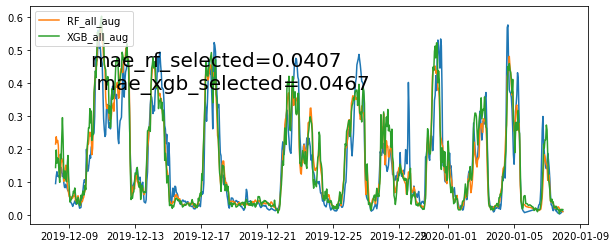

In [14]:
# Visualize the prediction results
plt.figure(figsize=(10,4))
# plt.plot(Y_tr.index,Y_tr.values)
plt.plot(Y_ts.index,Y_ts.values)
plt.plot(Y_ts.index,pred_RF1,label='RF_all_aug')
plt.plot(Y_ts.index,pred_XGB1,label='XGB_all_aug')
t='mae_rf_selected='+str(round(mae(Y_ts, pred_RF1),4))+'\n mae_xgb_selected='+str(round(mae(Y_ts, pred_XGB1),4))
plt.legend(loc='upper left')
plt.text(Y_ts.index[50], Y_ts.iloc[50]+0.2, t, fontsize=20)

### Dimension Reduction with Embedded Method witin the ML model

##### After feature augmentation in the previous step, we need to perform dimension reduction to remove redundant features that cause overfitting. This is done by comparing the model performance with the top n features (from 1 to 100 in this study) and select the optimal n with the best performance 
##### Since there are uncertainty involved in the RF model fitting, we use Monte Carlo simulation (MCS) to quantify this uncertaity. The results are compared in terms of the mean and standard deviation from multiple runs (ns=5 in this task).

In [21]:
# Start with the RF model
# getting importance scores from previous model with all augmented features
importance_scores_rf = pd.Series(dict(zip(X_tr.columns, model_RF1.feature_importances_)))

# Define number of random samples used in MCS
ns=5
n_max=100
# evaluate effects of number of features getting top n features
error_data_rf=pd.DataFrame(index=np.arange(ns), columns=np.arange(n_max))

for i in range(1,n_max):
    for j in range(ns):
        top_features = importance_scores_rf.sort_values(ascending=False)[:i]
        top_features_nm = top_features.index

        X_tr_top = X_tr[top_features_nm]
        X_ts_top = X_ts[top_features_nm]

        # re-fitting the model
        model_top_features = RandomForestRegressor()
        model_top_features.fit(X_tr_top, Y_tr)

        # getting forecasts for the test set
        preds_topf = model_top_features.predict(X_ts_top)

        # computing MAE error
        error_data_rf.iloc[j,i]=mae(Y_ts, preds_topf)

0.04053087878171962
18
Index(['WS_1193865|WS_1513782_conv_mean', 'WS_1133733|WS_1513782_conv_mean',
       'WS_2503597_cubic', 'WS_2503597_log', 'WS_2503597_squre',
       'WS_1513782|WS_1571308_conv_mean', 'WS_2503597_sqrt',
       'WS_1481513|WS_1513782_conv_mean', 'WS_1133733|WS_1193865_conv_mean',
       'WS_1193865|WS_2455069_conv_mean', 'WS_1513782|WS_2455069_conv_mean',
       'WS_1571308|WS_2455069_conv_mean', 'WS_1133733|WS_1571308_conv_mean',
       'WS_1193865|WS_1481513_conv_mean', 'WS_1481513|WS_1571308_conv_mean',
       'WS_2508550_cubic', 'WS_1358699_cubic', 'WS_78208_squre'],
      dtype='object')


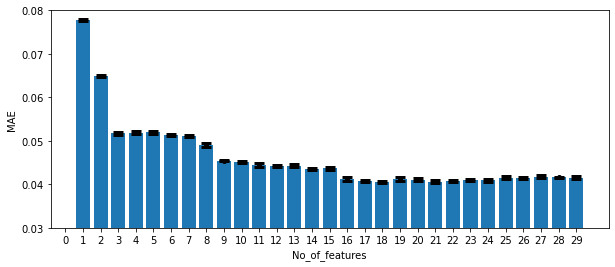

In [55]:
df_rf=pd.DataFrame()
df_rf['No_of_features']=np.arange(n_max)
df_rf['Mean']=0
df_rf['STD']=0

for i in range(n_max):
    df_rf['Mean'].iloc[i]=error_data_rf.iloc[:,i].mean()
    df_rf['STD'].iloc[i]=error_data_rf.iloc[:,i].std()

print(df_rf['Mean'].min())
# Shown the first 30 features to clearly show the trend
plt.figure(figsize=(10,4))
plt.errorbar( df_rf['No_of_features'].iloc[:30], df_rf['Mean'].iloc[:30], yerr=df_rf['STD'].iloc[:30], fmt='o', color='Black', elinewidth=3,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
plt.bar(df_rf['No_of_features'].iloc[:30], df_rf['Mean'].iloc[:30],tick_label = df_rf['No_of_features'].iloc[:30])##Bar plot
plt.xlabel('No_of_features')
plt.ylabel('MAE') 
plt.ylim((0.03,0.08)) 
# Optimal feature number = 18 with mean MAE of 0.4053
print(df_rf['Mean'].idxmin())
top_features = importance_scores_rf.sort_values(ascending=False)[:18]
top_features_rf = top_features.index
print(top_features_rf)
# The best average MAE is 0.04053, slightly better the the results with all the augmented features (0.0407)
# We observed a STD of 0.000X in the repeated runs, but this is insignificant compared with the mean of 0.0X.

In [23]:
# Also do the MCS for feature selectionon XGB model
# getting importance scores from previous model with all 96 features
importance_scores_xgb = pd.Series(dict(zip(X_tr.columns, model_xgb1.feature_importances_)))
# evaluate effects of number of features getting top n features
error_data_XGB=pd.DataFrame(index=np.arange(ns), columns=np.arange(n_max))

for i in range(1,n_max):
    for j in range(ns):
        top_features = importance_scores_xgb.sort_values(ascending=False)[:i]
        top_features_nm = top_features.index

        X_tr_top = X_tr[top_features_nm]
        X_ts_top = X_ts[top_features_nm]

        xgb_base = xgboost.XGBRegressor()
        xgb_base.fit(X_tr_top, Y_tr)

        predictions_xgb = xgb_base.predict(X_ts_top)

        # computing MAE error
        error_data_XGB.iloc[j,i]=mae(Y_ts, predictions_xgb)

0.04268994380261583
39


Index(['WS_2503597_squre', 'WS_1193865|WS_1513782_conv_mean',
       'WS_1133733|WS_1513782_conv_mean', 'WS_1133733|WS_1193865_conv_mean',
       'WS_1513782|WS_1571308_conv_mean', 'WS_921049_squre', 'WS_76004_squre',
       'WS_73494_squre', 'WS_1481513|WS_1513782_conv_mean', 'WS_78026_squre',
       'WS_1504146_squre', 'WS_1481513|WS_1571308_conv_mean',
       'WS_1513805_squre', 'WS_74022_squre', 'WS_75935_squre',
       'WS_631992_squre', 'WS_2508545_squre',
       'WS_1513782|WS_2455069_conv_mean'],
      dtype='object')

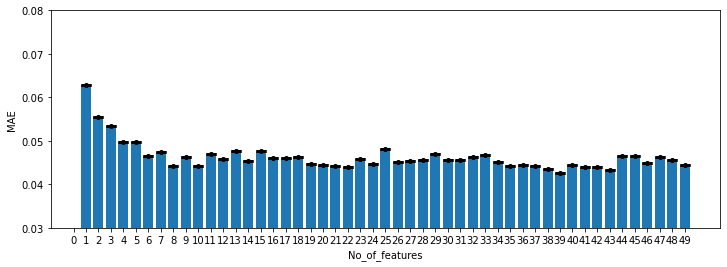

In [57]:
df_xgb=pd.DataFrame()
df_xgb['No_of_features']=np.arange(n_max)
df_xgb['Mean']=0
df_xgb['STD']=0

for i in range(n_max):
    df_xgb['Mean'].iloc[i]=error_data_XGB.iloc[:,i].mean()
    df_xgb['STD'].iloc[i]=error_data_XGB.iloc[:,i].std()
# Shown the first 50 features to clearly show the trend
plt.figure(figsize=(12,4))
plt.errorbar( df_xgb['No_of_features'].iloc[:50], df_xgb['Mean'].iloc[:50], yerr=df_xgb['STD'].iloc[:50], fmt='o', color='Black', elinewidth=3,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
plt.bar(df_xgb['No_of_features'].iloc[:50], df_xgb['Mean'].iloc[:50],tick_label = df_xgb['No_of_features'].iloc[:50])##Bar plot
plt.xlabel('No_of_features') ## Label on X axis
plt.ylabel('MAE') ##Label on Y axis
plt.ylim((0.03,0.08)) 
print(df_xgb['Mean'].min())
# Optimal feature number = 18 with mean MAE of 0.04269
# Improved from the MAE with all features 0.0467
print(df_xgb['Mean'].idxmin())
top_features = importance_scores_xgb.sort_values(ascending=False)[:18]
top_features_xgb = top_features.index
top_features_xgb
# Again, RF outperformed XGB (0.0405 vs 0.04268).
# The only thing is that the average STD of XGB is almost 0, which is less than that of RF. 
# This makes it more robust in repeated runs.

### Summary Before Model Hyper-parameter Tuning

##### As we can see from the results above, the MAEs of both RF and XGB models decrease after including the augmented features. This means the augmented features after transformations provides extra information to the model compared with the original features.
#### As of now, we have compare the performance of RF and XGB side by side three times. The findings can be found below

  - In this task, RF generally outperforms XGB in terms of MAE.
  - The computational cost of XGB during model fitting is much lowers than that of RF (e.g., 18s vs 0.8s when 96 features are used).
  - The uncertainty of RF during model fitting is generally higher than that of XGB (close to 0).

##### In this task, our main target is to achieve the best accuracy in terms of MAE in CF prediction. As a result, I'll select RF as the optimal model between the two in the following study. However, for other tasks that is more restricted on computational cost, e.g., when the algorithm is used in an Edge device for real-time fitting and prediction in each second, XGB will be a better option.

#### We'll continue refine the current best model: RF model with 18 selected features.

In [61]:
# Get the training/test set with 18 selected features
top_features_rf
X3 = X[top_features_rf]
# train/test split
X_tr3, X_ts3, Y_tr3, Y_ts3 = train_test_split(X3, Y0, test_size=0.2, shuffle=False)
X_tr3

,WS_1193865|WS_1513782_conv_mean,WS_1133733|WS_1513782_conv_mean,WS_2503597_cubic,WS_2503597_log,WS_2503597_squre,WS_1513782|WS_1571308_conv_mean,WS_2503597_sqrt,WS_1481513|WS_1513782_conv_mean,WS_1133733|WS_1193865_conv_mean,WS_1193865|WS_2455069_conv_mean,WS_1513782|WS_2455069_conv_mean,WS_1571308|WS_2455069_conv_mean,WS_1133733|WS_1571308_conv_mean,WS_1193865|WS_1481513_conv_mean,WS_1481513|WS_1571308_conv_mean,WS_2508550_cubic,WS_1358699_cubic,WS_78208_squre
DATETIME,,,,,,,,,,,,,,,,,,
2019-08-07 00:00:00,85.9740,99.9810,1622.234375,2.463853,138.0625,106.4532,3.427827,149.3436,92.1150,80.0110,86.8434,99.0698,114.0570,137.5940,170.3692,1693.669888,1.560896,123.6544
2019-08-07 01:00:00,76.5282,93.0230,1589.324463,2.457021,136.1889,93.3107,3.416138,142.8910,77.4060,71.1816,85.5428,86.7916,94.3810,118.9020,144.9770,1723.683599,0.912673,109.6209
2019-08-07 02:00:00,74.6102,86.6936,1469.878353,2.430978,129.2769,85.5428,3.371943,136.3698,70.3312,70.0978,86.4059,80.3692,80.6368,110.6316,126.8424,1685.159000,0.778688,102.0100
2019-08-07 03:00:00,73.8208,82.8832,1423.828125,2.420368,126.5625,81.1840,3.354102,127.7232,68.6596,73.1170,88.2640,80.4100,75.5080,105.8046,116.3580,1659.797504,0.314432,93.5089
2019-08-07 04:00:00,61.1800,75.7160,1249.243533,2.376764,115.9929,66.1480,3.281768,118.1280,54.7295,61.0470,84.4560,66.0042,59.1737,85.3860,92.3196,1462.135375,0.205379,85.3776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-07 23:00:00,92.7146,50.9133,1647.212741,2.468947,139.4761,60.7087,3.436568,42.1430,36.3858,48.7586,68.2261,31.9267,23.8251,30.1180,19.7210,2092.240639,1962.515008,38.4400
2019-12-08 00:00:00,86.3691,54.2531,1316.532736,2.394252,120.1216,63.7732,3.310589,40.4891,35.6169,41.7915,63.6585,30.8580,26.2988,26.5809,19.6268,1851.804352,1710.777536,41.0881
2019-12-08 01:00:00,74.2590,53.9460,1420.034624,2.419479,126.3376,60.9390,3.352611,35.8530,32.5134,35.9253,59.6070,29.4813,26.6814,21.6087,17.7327,1749.690125,1664.006625,44.3556


#### Rough Parameter Search

In [62]:
# Create a parameter grid to sample from during fitting

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [64]:
# Use the random grid to search for best hyperparameters
# In total, there are 5 * 2 * 11 * 3 * 3  * 2 = 1980 combinations in the grid
# However, the benefit of a random search is that we are not trying every combination, 
# but selecting at random to sample a wide range of values.

# First create the base model to tune
# Fixing the random state will help remove the randomness in other parameters during model fitting
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 300 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv=2,n_iter=100)
# Fit the random search model
rf_random.fit(X_tr3,Y_tr3)

rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [65]:
# Evaluate the improvement with the optimal parameter after random search
def evaluate(model, X_ts, Y_ts):
    predictions = model.predict(X_ts)
    errors = abs(predictions - Y_ts)
    mae = np.mean(errors)
    print('Model Performance')
    print('MAE: {:0.4f}.'.format(np.mean(mae)))
    return mae

base_model = RandomForestRegressor(random_state=1)
base_model.fit(X_tr3,Y_tr3)
mae_base = evaluate(base_model, X_ts3, Y_ts3)

best_random = RandomForestRegressor(n_estimators=200,
                                    min_samples_split=10,
                                    min_samples_leaf=1,
                                    max_features="sqrt",
                                    max_depth=50,                                    
                                    bootstrap=True,random_state=9)
best_random.fit(X_tr3,Y_tr3)
mae_best = evaluate(best_random,  X_ts3, Y_ts3)

print('Improvement of {:0.4f}%.'.format( 100 * (mae_base-mae_best) / mae_base))

# As we can see from the result, we achieved a 2.26% improvement after a rough random search over a large parameter grid space.
# Next, we'll continue improving the model with fine tuning that focuses on the most promising region.

Model Performance
MAE: 0.0406.
Model Performance
MAE: 0.0397.
Improvement of 2.2556%.


### Fine Parameter Tuning

In [66]:
# We can further improve our results by using grid search to focus on the most promising hyperparameters 
# ranges found in the random search.

# {'n_estimators': 200,
#  'min_samples_split': 10,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': 50,
#  'bootstrap': True}

# Create the parameter grid based on the results of random search 
param_grid = {'n_estimators': [150,200,250],
          'min_samples_split': [9,10,11],
          'min_samples_leaf': [1,2,3],
          'max_features': ['sqrt'],
          'max_depth': [45,50,55],
          'bootstrap': [True]}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid)

# Fit the grid search to the data
grid_search.fit(X_tr3,Y_tr3)
grid_search.best_params_


{'bootstrap': True,
 'max_depth': 55,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'n_estimators': 150}

In [70]:
best_random = RandomForestRegressor(max_depth=50,
                                    max_features="sqrt",
                                    min_samples_split=10,
                                    min_samples_leaf=1,
                                    n_estimators=200,
                                    bootstrap=True,random_state=2)
best_random.fit(X_tr3,Y_tr3)
mae_best_random = evaluate(best_random,  X_ts3, Y_ts3)

best_grid = RandomForestRegressor(max_depth=55,
                                    max_features="sqrt",
                                    min_samples_split=9,
                                    min_samples_leaf=1,
                                    n_estimators=150,
                                    bootstrap=True,random_state=2)
best_grid.fit(X_tr3,Y_tr3)
mae_best_grid = evaluate(best_grid, X_ts3, Y_ts3)

print('Improvement of {:0.4f}%.'.format( 100 * (mae_best_random-mae_best_grid) / mae_best_random))

# After the fine grid search, we achieved an improvement in accuracy of 0.9%. 
# Depending on the application though, this could be a significant benefit.

Model Performance
MAE: 0.0397.
Model Performance
MAE: 0.0393.
Improvement of 0.8957%.


## Now the optimal parameters for the RF model have been identified, the RF model is ready for predicting the CF in this task.


### Before running the optimal RF model on the test data in this task, I will include two investigations

  - What if the historical data of CF/WS are all available as input variables?
  - How would a statistical model (such as Prophet or SARIMAX) perform in the prediction compared with a ML model?

#### Investigation 1: 
##### What if the previous measurements of WS/CF are also used as an input variables?
##### This doesn't apply to this task though because the predictions on all the 94 column are required at the same time.
##### However, if one step ahead forecasting is required, then we can include the WS(t-n), CF(t-1) as variabless with a Bayisien approch i.e., keep updating the training data once new measurements become available.
#### Note: This investigation is not for solving this task, only to demontrate the accuracy improvement for one-step ahead prediction.

In [73]:
# In one step ahead forecasting, CF(t-1), WS(t-1), WS(t-2)...CF(t-n)
# can also be used to predict CF(t) together with other variables
# Through the same feature selection procedure before,'WS_1513782(t)', 'WS_1133733(t)', 'WS_1504146(t-1)', 'CF(t-1)' are selected.
# defining target (Y) and explanatory variables (X)

# create data set with lagged features using time delay embedding with maximum time lag of 24
Y=df_train.loc[:, 'CF']
df_train_selected=df_train_selected.assign(CF = Y.tolist())
features_with_lag = []
for col in df_train_selected:
    col_df = time_delay_embedding(df_train_selected[col], n_lags=24, horizon=1)
    features_with_lag.append(col_df)
# Concatenating all features
allfeature_df=pd.concat(features_with_lag, axis=1).dropna()

# The process for feature selection will be the same with the previous steps, I'll skip it here to avoid a lengthy notebook.
input_cols = ['WS_1513782(t)', 'WS_1133733(t)', 'CF(t-1)']

X2 = allfeature_df[input_cols]
Y2 = allfeature_df['CF(t)']
X2.columns

# Here we can see that 'WS_1513782(t)', 'WS_1133733(t)', 'WS_1504146(t-1)', 'CF(t-1)' are included in the candidate features.


Index(['WS_1513782(t)', 'WS_1133733(t)', 'CF(t-1)'], dtype='object')

0.02524281122671739


Text(2019-12-25 18:00:00, 0.26862031757220406, 'mae_rf=0.0252')

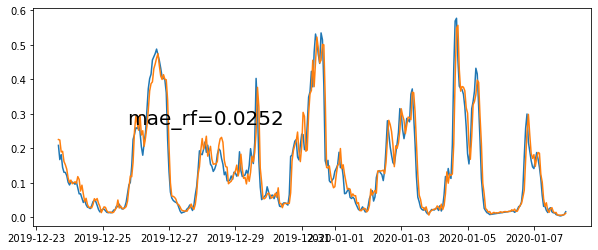

In [74]:
# train/test split
X_tr2, X_ts2, Y_tr2, Y_ts2 = train_test_split(X2, Y2, test_size=0.1, shuffle=False)

# fitting a RF model
model = RandomForestRegressor()
model.fit(X_tr2, Y_tr2)

# getting forecasts for the test set
pred_RFCF = model.predict(X_ts2)


# computing MAE error
print(mae(Y_ts2, pred_RFCF))

plt.figure(figsize=(10,4))
# plt.plot(Y_tr.index,Y_tr.values)
plt.plot(Y_ts2.index,Y_ts2.values)
plt.plot(Y_ts2.index,pred_RFCF)

t='mae_rf='+str(round(mae(Y_ts2, pred_RFCF),4))
plt.text(Y_ts2.index[50], Y_ts2.iloc[50]+0.2, t, fontsize=20)

# From the result, we can see that the MAE almost decreased by around 50% (0.0235 vs 0.0405) 
# if one-step head prediction is the goal.

In [ ]:
# In the one-step ahead prediction, only the CF at the next one hour are predicted based on all the information at the current hour.
# To demonstrate how a new CF is predicted, I generated an animation with the follow codes.
!pip install opencv-python
import cv2
def figure_to_array(fig):
    fig.canvas.draw()
    return np.array(fig.canvas.renderer._renderer)

img_size = (1600,1200)

# configure video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("onestepahead_pred.mp4", fourcc, 1, img_size)

interval=1

start_ind=100

x_length=20

for i in range(len(Y_ts2)-start_ind):
   
    j = interval * i+start_ind

    pred_display=pred_RFCF[j-x_length:j]

    yts_display=Y_ts2.iloc[j-x_length:j]

    xts_display=X_ts2.iloc[j-x_length:j]
    
    fig, ax = plt.subplots(3, figsize=(6, 6), sharex=True)
    
    fig.suptitle("1-step ahead prediction on CF")
    
    ax[0].cla()
    ax[0].plot(yts_display.index, pred_display,color="r",label = 'predicted CF')
    
    ax[0].plot(yts_display.index, yts_display.values,color="g",label = 'true CF')

    ax[0].set_ylim((0, 0.6))


    ax[0].set_ylabel(f"CF")
    ax[0].legend(loc='upper left')
    ax[0].grid(True)
    
    ax[1].cla()
    ax[1].plot(xts_display.index, xts_display['CF(t-1)'])
    ax[1].set_ylabel(f"Feature: CF(t-1)")
    ax[1].set_ylim((0, 0.6))
    ax[1].grid(True)  
    
    ax[2].cla()
    ax[2].plot(xts_display.index, xts_display['WS_1513782(t)'])
    ax[2].set_ylabel(f"Feature: WS_1513782(t)")
    ax[2].set_ylim((0, 20))
    ax[2].grid(True) 
    
    plt.close()    
    f_arr = figure_to_array(fig)
    f_arr = cv2.resize(f_arr, img_size)

    bgr = cv2.cvtColor(f_arr, cv2.COLOR_RGBA2BGR)
    out.write(bgr)    
out.release() 

### Investigation 2: 
#### How would a statistical model (such as Prophet or SARIMAX) perform in the prediction compared with the RF model?
#### Here, I selected both Prophet and SARIMAX model to solve this task. However, the dependant packages on Prophet is too completed and makes it difficult for you to replicate the results. Thus, I only included the SARIMAX model in this notebook. From the results, the overall performance is not as good as a ML model. This is possibly due to the lack of information on the wind power when the test data are predicted. (Wind power data are available in the test data, but statistical models don't use these data in the training process)

In [75]:
# Check for the stationary of the data before using any time-series statistical model
#We can use or adfuller test to verify the stationary of the data
# Null Hypothesis: Series is not stationary

for i in range(len(df_train_selected.columns)):
    result=adfuller(df_train_selected[df_train_selected.columns[i]])

    # Use 0.05 as the static p value to test stationary
    # If non-stationary, try differencing to make it stationary
    if result[1]>0.05:
        print("Series is not stationary:", df_train_selected.columns[i], result[1])
        result=adfuller(df_train_selected.iloc[:i].diff()[1:])
        print("Adjusted result by differencing is:", df_train_selected.columns[i], result[1])

    else:
        print("Series is stationary:", df_train_selected.columns[i], result[1])

# df_train_selected=df_train_selected.drop('')
#creating the train and validation set
train = df_train_selected[:int(0.9*(len(df_train_selected)))]
test = df_train_selected[int(0.9*(len(df_train_selected))):]


Series is stationary: WS_1133733 1.2370778292800314e-11
Series is stationary: WS_1193865 2.0285257124053939e-10
Series is stationary: WS_1461024 2.279868130265861e-12
Series is stationary: WS_1481513 7.67322963581268e-14
Series is stationary: WS_1513782 1.2964723735904204e-17
Series is stationary: WS_1571308 3.9453701777715246e-10
Series is stationary: WS_1820276 2.8411226607522067e-15
Series is stationary: WS_2455069 1.2089585970578498e-12
Series is stationary: WS_594133 3.64959319376343e-12
Series is stationary: WS_914573 3.658338134953405e-12
Series is stationary: CF 4.716320504926211e-14


In [77]:
#Seasonal ARIMAX Model (with wind power as exogenous variables) 
# The training step is time-consuming (15 min+) due to the search for the optimal parameters.

exogenous_features=['WS_1133733','WS_1193865']
# SARIMAX Model
SARIMAX_model = pm.auto_arima(train.CF, exogenous=train[exogenous_features],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=2, max_q=2, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.fit(train.CF, exogenous=train[exogenous_features])
pred_ARIMAX = SARIMAX_model.predict(n_periods=len(test), exogenous=test[exogenous_features])
test["pred_ARIMAX"] = pred_ARIMAX

<ipython-input-77-dc9da9e17b4b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred_ARIMAX"] = pred_ARIMAX


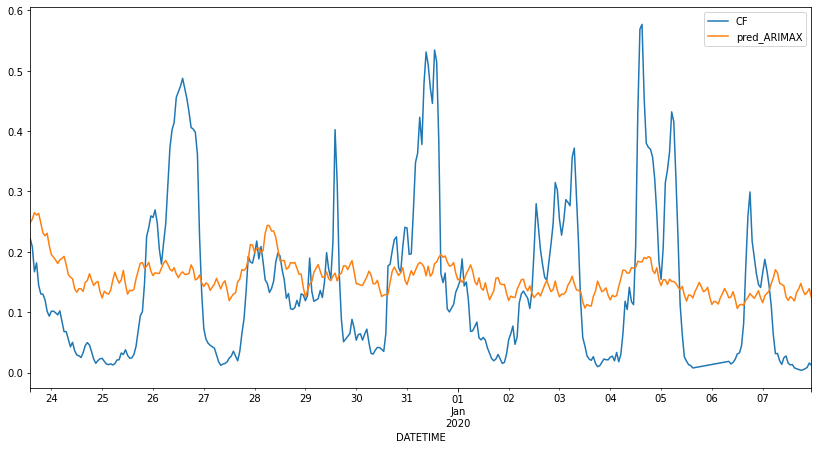

In [78]:
test[["CF", "pred_ARIMAX"]].plot(figsize=(14, 7))
# As we can see, the SARIMAX almost failed in predicting the future trends of CF due to the limited training data 
# and long prediction horizon. Without input variables (WS) that are used in a ML model at each new timestamp, 
# the information will vanish, which caused the poor predictin accuracy thereafter.

## Final Step: Prediction on the Test Data with a RF model with optimal feature and parameter 

In [90]:
# Get the test dateset
test_ds=df_pred_raw.copy()
test_ds_selected=test_ds[selected_columns]
X_test=test_ds_selected.copy()

# Use all the known data as the training set
# Select the optimal features
X_train_final=X[top_features_rf]
Y_train_final=Y0

In [80]:
# Univariate feature transformation for test data

X_raw=test_ds.drop('CF',axis=1)
colnames=X_raw.columns.tolist()

# Check whether any value is 0 to avoid -inf after log transformation.
print(X_raw.eq(0).any().any())

Univariate_Transformation = {
    'squre': square,
    'cubic': cubic,
    'sqrt': sqrt,
    'log': log,
}

univariate_features = {}
# for each column in the data
for col in colnames:
    # get lags for that column
    X_col = X_raw.iloc[:, X_raw.columns.str.startswith(col)]
    # for each summary stat
    for feat, func in Univariate_Transformation.items():
        # compute that stat along the rows
        univariate_features[f'{col}_{feat}'] = X_col.apply(func, axis=1)
# concatenate features into a pd.DF
univariate_features_df = pd.concat(univariate_features, axis=1)
univariate_features_df.columns = univariate_features_df.columns.droplevel(1)
univariate_features_df

# After this step, 448 features are added.

False


,WS_1133733_squre,WS_1133733_cubic,WS_1133733_sqrt,WS_1133733_log,WS_1156770_squre,WS_1156770_cubic,WS_1156770_sqrt,WS_1156770_log,WS_1156968_squre,WS_1156968_cubic,...,WS_918665_sqrt,WS_918665_log,WS_920775_squre,WS_920775_cubic,WS_920775_sqrt,WS_920775_log,WS_921049_squre,WS_921049_cubic,WS_921049_sqrt,WS_921049_log
DATETIME,,,,,,,,,,,,,,,,,,,,,
2020-01-09 00:00:00,2.8561,4.826809,1.300000,0.524729,3.5344,6.644672,1.371131,0.631272,9.9225,31.255875,...,1.072381,0.139762,1.8225,2.460375,1.161895,0.300105,2.1316,3.112136,1.208305,0.378436
2020-01-09 01:00:00,2.5600,4.096000,1.264911,0.470004,4.0804,8.242408,1.421267,0.703098,15.2881,59.776471,...,1.131371,0.246860,2.2201,3.307949,1.220656,0.398776,1.6641,2.146689,1.135782,0.254642
2020-01-09 02:00:00,3.2041,5.735339,1.337909,0.582216,4.5796,9.800344,1.462874,0.760806,17.6400,74.088000,...,1.249000,0.444686,2.3716,3.652264,1.240967,0.431782,2.4336,3.796416,1.249000,0.444686
2020-01-09 03:00:00,4.0401,8.120601,1.417745,0.698135,5.3824,12.487168,1.523155,0.841567,26.7289,138.188413,...,1.456022,0.751416,2.7556,4.574296,1.288410,0.506818,4.7524,10.360232,1.476482,0.779325
2020-01-09 04:00:00,4.4944,9.528128,1.456022,0.751416,6.4516,16.387064,1.593738,0.932164,17.5561,73.560059,...,1.526434,0.845868,4.7089,10.218313,1.473092,0.774727,6.7600,17.576000,1.612452,0.955511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-12 16:00:00,9.7344,30.371328,1.766352,1.137833,6.8644,17.984728,1.618641,0.963174,16.3216,65.939264,...,1.833030,1.211941,28.0900,148.877000,2.302173,1.667707,20.7025,94.196375,2.133073,1.515127
2020-01-12 17:00:00,7.7841,21.717639,1.670329,1.026042,5.3361,12.326391,1.519868,0.837248,18.0625,76.765625,...,1.649242,1.000632,21.4369,99.252847,2.151743,1.532557,14.5161,55.306341,1.951922,1.337629
2020-01-12 18:00:00,8.1796,23.393656,1.691153,1.050822,5.9536,14.526784,1.562050,0.891998,15.6025,61.629875,...,1.593738,0.932164,18.2329,77.854483,2.066398,1.451614,11.6964,40.001688,1.849324,1.229641


In [87]:
# Bivariate feature transformation for test set

X0_test=X_raw[selected_columns]
colnames=X0_test.columns.tolist()

SUMMARY_STATS = {
    'mean': np.mean
}

BIVARIATE_TRANSFORMATIONS = {
    'conv': signal.convolve
}


# get all pairs of variables
col_combs = list(itertools.combinations(colnames, 2))

interaction_features = []
# for each row
for i, _ in X0_test.iterrows():
    # feature set in the i-th time-step
    feature_set_i = {}
    for col1, col2 in col_combs:
        # features for pair of columns col1, col2

        # getting the i-th instance for each column
        x1 = X0_test.loc[i, X0_test.columns.str.startswith(col1)]
        x2 = X0_test.loc[i, X0_test.columns.str.startswith(col2)]

        # for each transformation
        for trans_f, t_func in BIVARIATE_TRANSFORMATIONS.items():

            # apply transformation
            xt = t_func(x1, x2)

            # compute summary stat
            for feat, s_func in SUMMARY_STATS.items():
                feature_set_i[f'{col1}|{col2}_{trans_f}_{feat}'] = s_func(xt)

    interaction_features.append(feature_set_i)

bivariate_features_df = pd.DataFrame(interaction_features, index=X0_test.index)

bivariate_features_df
# As we can see from the results, the 45 interactions among the 10 variable pair are added to the feature space.

,WS_1133733|WS_1193865_conv_mean,WS_1133733|WS_1461024_conv_mean,WS_1133733|WS_1481513_conv_mean,WS_1133733|WS_1513782_conv_mean,WS_1133733|WS_1571308_conv_mean,WS_1133733|WS_1820276_conv_mean,WS_1133733|WS_2455069_conv_mean,WS_1133733|WS_594133_conv_mean,WS_1133733|WS_914573_conv_mean,WS_1193865|WS_1461024_conv_mean,...,WS_1571308|WS_1820276_conv_mean,WS_1571308|WS_2455069_conv_mean,WS_1571308|WS_594133_conv_mean,WS_1571308|WS_914573_conv_mean,WS_1820276|WS_2455069_conv_mean,WS_1820276|WS_594133_conv_mean,WS_1820276|WS_914573_conv_mean,WS_2455069|WS_594133_conv_mean,WS_2455069|WS_914573_conv_mean,WS_594133|WS_914573_conv_mean
DATETIME,,,,,,,,,,,,,,,,,,,,,
2020-01-09 00:00:00,3.8363,2.6871,1.8590,2.4336,2.0787,1.8421,1.9604,2.1463,1.8928,3.6093,...,1.3407,1.4268,1.5621,1.3776,1.2644,1.3843,1.2208,1.4732,1.2992,1.4224
2020-01-09 01:00:00,3.7760,2.6560,2.0480,2.2080,3.1200,1.7600,1.6480,1.4240,1.6480,3.9176,...,2.1450,2.0085,1.7355,2.0085,1.1330,0.9790,1.1330,0.9167,1.0609,0.9167
2020-01-09 02:00:00,3.6874,3.2578,2.3091,2.9356,5.2626,1.6110,1.6289,1.4141,1.9690,3.7492,...,2.6460,2.6754,2.3226,3.2340,0.8190,0.7110,0.9900,0.7189,1.0010,0.8690
2020-01-09 03:00:00,4.6431,3.4572,2.0904,4.5627,7.4973,1.6482,1.5678,1.7286,2.1306,3.9732,...,3.0586,2.9094,3.2078,3.9538,0.6396,0.7052,0.8692,0.6708,0.8268,0.9116
2020-01-09 04:00:00,9.5824,4.7276,2.2896,5.7028,4.5580,2.3320,2.6288,1.8020,2.2896,10.0796,...,2.3650,2.6660,1.8275,2.3220,1.3640,0.9350,1.1880,1.0540,1.3392,0.9180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-12 16:00:00,3.3384,6.1152,6.8640,13.3224,6.2400,14.4768,18.0336,19.4376,16.0992,2.0972,...,9.2800,11.5600,12.4600,10.3200,26.8192,28.9072,23.9424,36.0094,29.8248,32.1468
2020-01-12 17:00:00,4.4361,4.5198,4.3524,9.9324,5.4963,12.6666,15.2334,17.1306,12.8061,2.5758,...,8.9438,10.7562,12.0958,9.0423,24.7884,27.8756,20.8386,33.5244,25.0614,28.1826
2020-01-12 18:00:00,7.3788,5.9202,5.0050,8.8374,6.0632,12.8986,12.6984,17.5890,13.6422,5.3406,...,9.5612,9.4128,13.0380,10.1124,20.0244,27.7365,21.5127,27.3060,21.1788,29.3355


In [89]:
# Get X_test based on the 18 optimal features

X_test_all=pd.concat([X0_test,univariate_features_df,bivariate_features_df], axis=1)
print(X_test_all.shape[1])

X_test_final=X_test_all[top_features_rf]
X_test_final

503


,WS_1193865|WS_1513782_conv_mean,WS_1133733|WS_1513782_conv_mean,WS_2503597_cubic,WS_2503597_log,WS_2503597_squre,WS_1513782|WS_1571308_conv_mean,WS_2503597_sqrt,WS_1481513|WS_1513782_conv_mean,WS_1133733|WS_1193865_conv_mean,WS_1193865|WS_2455069_conv_mean,WS_1513782|WS_2455069_conv_mean,WS_1571308|WS_2455069_conv_mean,WS_1133733|WS_1571308_conv_mean,WS_1193865|WS_1481513_conv_mean,WS_1481513|WS_1571308_conv_mean,WS_2508550_cubic,WS_1358699_cubic,WS_78208_squre
DATETIME,,,,,,,,,,,,,,,,,,
2020-01-09 00:00:00,3.2688,2.4336,0.571787,-0.186330,0.6889,1.7712,0.911043,1.5840,3.8363,2.6332,1.6704,1.4268,2.0787,2.4970,1.3530,1.259712,26.463592,1.9600
2020-01-09 01:00:00,3.2568,2.2080,1.367631,0.104360,1.2321,2.6910,1.053565,1.7664,3.7760,2.4308,1.4214,2.0085,3.1200,3.0208,2.4960,0.778688,22.665187,1.0404
2020-01-09 02:00:00,3.3784,2.9356,0.912673,-0.030459,0.9409,4.8216,0.984886,2.1156,3.6874,1.8746,1.4924,2.6754,5.2626,2.6574,3.7926,0.636056,28.934443,1.9321
2020-01-09 03:00:00,5.2437,4.5627,1.157625,0.048790,1.1025,8.4671,1.024695,2.3608,4.6431,1.8018,1.7706,2.9094,7.4973,2.4024,3.8792,1.685159,38.614472,2.4025
2020-01-09 04:00:00,12.1588,5.7028,0.704969,-0.116534,0.7921,5.7835,0.943398,2.9052,9.5824,5.6048,3.3356,2.6660,4.5580,4.8816,2.3220,2.685619,54.439939,2.6896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-12 16:00:00,4.5689,13.3224,14.706125,0.896088,6.0025,8.5400,1.565248,9.3940,3.3384,6.1846,24.6806,11.5600,6.2400,2.3540,4.4000,28.934443,274.625000,15.4449
2020-01-12 17:00:00,5.6604,9.9324,7.880599,0.688135,3.9601,7.0132,1.410674,5.5536,4.4361,8.6814,19.4376,10.7562,5.4963,2.4804,3.0732,16.387064,408.518488,12.8164
2020-01-12 18:00:00,7.9722,8.8374,8.000000,0.693147,4.0000,6.5508,1.414214,5.4075,7.3788,11.4552,13.7196,9.4128,6.0632,4.5150,3.7100,10.360232,398.688256,13.1044


In [91]:

# Train a RF model with the optimized parameters
best_grid_final = RandomForestRegressor(max_depth=55,
                                    max_features="sqrt",
                                    min_samples_split=9,
                                    min_samples_leaf=1,
                                    n_estimators=150,
                                    bootstrap=True)
best_grid_final.fit(X_train_final,Y_train_final)

# Predict the unknown CF with the other WS variables
Y_pred_final = best_grid_final.predict(X_test_final)

# Add the predicted data to the column
df_pred_final=df_pred_raw.copy()
df_pred_final=df_pred_final.assign(CF=Y_pred_final)

# Save the df as csv
df_pred_final.to_csv('data/Wind_data_predicted_V2.csv')

Text(0, 0.5, 'wind power WS_1513782')

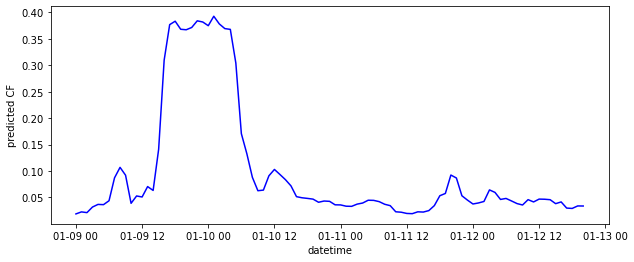

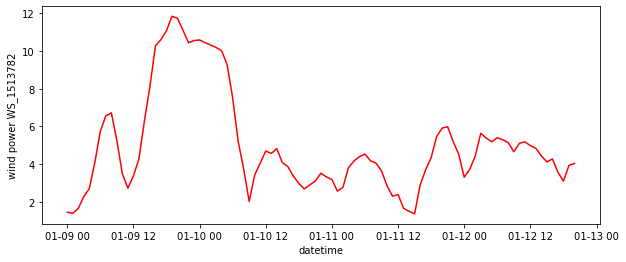

In [92]:
# A quick check on whether the prediction is meaningful.
# Select the column that is most correlated with CF
df_pred_final

plt.figure(figsize=(10,4))
plt.plot(df_pred_final.index,df_pred_final.CF, color='b')
plt.xlabel('datetime') ## Label on X axis
plt.ylabel('predicted CF') ##Label on Y axis

plt.figure(figsize=(10,4))
plt.plot(df_pred_final.index,df_pred_final.WS_1513782,color='r')
plt.xlabel('datetime') ## Label on X axis
plt.ylabel('wind power WS_1513782') ##Label on Y axis

# From the figure, the trend of the CF (red) generally follows that of WS_1513782 (blue).
# The model fitting should has been performed as expected.